In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import time
from torchsummary import summary
from torch.optim import lr_scheduler
import copy

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
from collections import OrderedDict
import shutil 

In [2]:
# Move images so that dataloader can handle it
class_maps = OrderedDict()
with open('./data/tiny-imagenet-200/val/val_annotations.txt', "r") as f:
    for line in f:
        one_line = line.split()
        class_maps[one_line[0]] = one_line[1]
# print(class_maps)

val_path = './data/tiny-imagenet-200/val/'
for image, class_name in class_maps.items():
    if not os.path.exists(val_path+'{}'.format(class_name)):
        try:
            os.makedirs(val_path+'{}/images'.format(class_name))
        except OSError as e:
            raise e
    if os.path.exists(val_path+'images'):
        source = val_path + 'images/{}'.format(image)
        destination = val_path + '{}/images/'.format(class_name)
        shutil.move(source, destination)

# remove the original image directory
if os.path.exists(val_path+'images'):
    os.rmdir(val_path + 'images')

In [3]:
# Load the Data
data_dir = './data/tiny-imagenet-200'
num_classes = 200

# Create the training data generator
batch_size = 500
im_height = 64
im_width = 64
phases = ['train', 'val', 'test']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    

def load_data(batch_size=500, data_aug=False):
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
    ])
    
    train_data_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(),
        transforms.RandomRotation(45),
        transforms.ColorJitter(),
#         transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0, 0, 0), tuple(np.sqrt((255, 255, 255)))),
    ])
    
    if data_aug:
        # Load Data from folders
        image_datasets = {
            'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_data_transforms),
            'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms),
            'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms)
        }
    else:
        image_datasets = {
            'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=data_transforms),
            'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=data_transforms),
            'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transforms)
        }

    # subset_indices = np.random.permutation(range(100))
    # dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, 
    #                              sampler=SubsetRandomSampler(subset_indices)) for x in phases}

    dataloaders = {'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True),
                  'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=True),
                  'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False)}
    dataset_sizes = {x: len(image_datasets[x]) for x in phases}
    class_names = image_datasets['train'].classes
    return image_datasets, dataloaders, dataset_sizes, class_names

image_datasets, dataloaders, dataset_sizes, class_names = load_data()
print(dataset_sizes)

{'train': 100000, 'val': 10000, 'test': 10000}


In [4]:
def plot_result(x_scale, tr, val, title, y_label):
    plt.title(title)
    if title == 'loss':
        plt.plot(x_scale, tr, label='training loss')
        plt.plot(x_scale, val, label='validation loss')
    else:
        plt.plot(x_scale, tr, label='training accuracy')
        plt.plot(x_scale, val, label='validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    tr_acc, val_acc = [], []
    tr_loss, val_loss  = [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
#                 with torch.set_grad_enabled(phase == 'train'):
                if phase == 'train':
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                tr_acc.append(epoch_acc)
                tr_loss.append(epoch_loss)
            elif phase == 'val':
                val_acc.append(epoch_acc)
                val_loss.append(epoch_loss)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, tr_acc, val_acc, tr_loss, val_loss

### Resnet18

In [5]:
# Load the pretrained model
model = models.resnet18(pretrained=True)

# Freeze model parameters to train only the last layer. 
# Comment out this cell if you want to fine tune the whole network
for param in model.parameters():
    param.requires_grad = False

In [9]:
# Change the final layer to fit 200 classes (Transfer Learning)
num_ftrs = model.fc.in_features
# model.fc = nn.Sequential(
#     nn.Linear(fc_inputs, 256),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(256, num_classes),
#     nn.LogSoftmax(dim=1) # For using NLLLoss()
# )
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [29]:
# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
# learning_rates = [0.00001, 0.0001, 0.001]
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)
model, tr_acc, val_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 3.6905 Acc: 0.1796
val Loss: 3.2401 Acc: 0.2418

Epoch 1/9
----------
train Loss: 2.9219 Acc: 0.3066
val Loss: 2.8574 Acc: 0.3201

Epoch 2/9
----------
train Loss: 2.5039 Acc: 0.3879
val Loss: 2.7000 Acc: 0.3709

Epoch 3/9
----------
train Loss: 2.1565 Acc: 0.4573
val Loss: 3.4735 Acc: 0.2834

Epoch 4/9
----------
train Loss: 1.8196 Acc: 0.5286
val Loss: 2.5971 Acc: 0.4002

Epoch 5/9
----------
train Loss: 0.9916 Acc: 0.7257
val Loss: 2.9134 Acc: 0.4372

Epoch 6/9
----------
train Loss: 0.7121 Acc: 0.7957
val Loss: 2.9663 Acc: 0.4410

Epoch 7/9
----------
train Loss: 0.5288 Acc: 0.8430
val Loss: 3.3291 Acc: 0.4246

Epoch 8/9
----------
train Loss: 0.3894 Acc: 0.8826
val Loss: 3.8035 Acc: 0.4209

Epoch 9/9
----------
train Loss: 0.2846 Acc: 0.9127
val Loss: 4.1252 Acc: 0.4147

Training complete in 70m 31s
Best val Acc: 0.441000


##### Fine tune the last layer

learning rate: 1e-05
Epoch 0/9
----------
train Loss: 5.5906 Acc: 0.0055
val Loss: 5.4923 Acc: 0.0074

Epoch 1/9
----------
train Loss: 5.4371 Acc: 0.0085
val Loss: 5.3715 Acc: 0.0111

Epoch 2/9
----------
train Loss: 5.3236 Acc: 0.0135
val Loss: 5.2677 Acc: 0.0155

Epoch 3/9
----------
train Loss: 5.2230 Acc: 0.0197
val Loss: 5.1720 Acc: 0.0232

Epoch 4/9
----------
train Loss: 5.1272 Acc: 0.0272
val Loss: 5.0793 Acc: 0.0309

Epoch 5/9
----------
train Loss: 5.0356 Acc: 0.0377
val Loss: 4.9925 Acc: 0.0410

Epoch 6/9
----------
train Loss: 4.9466 Acc: 0.0481
val Loss: 4.9074 Acc: 0.0508

Epoch 7/9
----------
train Loss: 4.8615 Acc: 0.0609
val Loss: 4.8263 Acc: 0.0637

Epoch 8/9
----------
train Loss: 4.7793 Acc: 0.0739
val Loss: 4.7481 Acc: 0.0763

Epoch 9/9
----------
train Loss: 4.7007 Acc: 0.0869
val Loss: 4.6758 Acc: 0.0890

Training complete in 12m 54s
Best val Acc: 0.089000


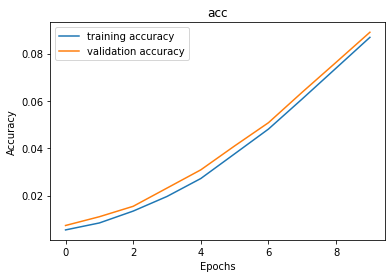

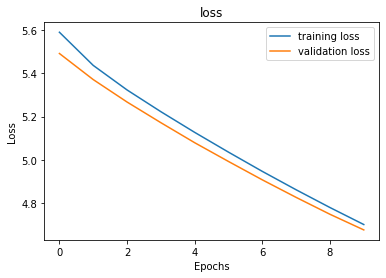


learning rate: 0.0001
Epoch 0/9
----------
train Loss: 5.1245 Acc: 0.0372
val Loss: 4.6886 Acc: 0.0870

Epoch 1/9
----------
train Loss: 4.3645 Acc: 0.1465
val Loss: 4.1205 Acc: 0.1854

Epoch 2/9
----------
train Loss: 3.8946 Acc: 0.2265
val Loss: 3.7730 Acc: 0.2413

Epoch 3/9
----------
train Loss: 3.6014 Acc: 0.2694
val Loss: 3.5565 Acc: 0.2708

Epoch 4/9
----------
train Loss: 3.4075 Acc: 0.2947
val Loss: 3.4137 Acc: 0.2869

Epoch 5/9
----------
train Loss: 3.2713 Acc: 0.3112
val Loss: 3.3091 Acc: 0.2990

Epoch 6/9
----------
train Loss: 3.1709 Acc: 0.3245
val Loss: 3.2398 Acc: 0.3076

Epoch 7/9
----------
train Loss: 3.0926 Acc: 0.3338
val Loss: 3.1825 Acc: 0.3150

Epoch 8/9
----------
train Loss: 3.0302 Acc: 0.3418
val Loss: 3.1380 Acc: 0.3210

Epoch 9/9
----------
train Loss: 2.9784 Acc: 0.3500
val Loss: 3.1036 Acc: 0.3263

Training complete in 12m 57s
Best val Acc: 0.326300


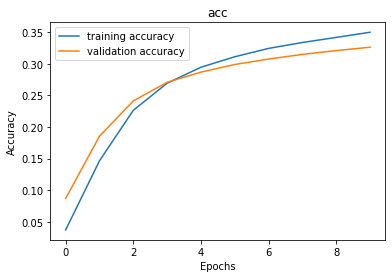

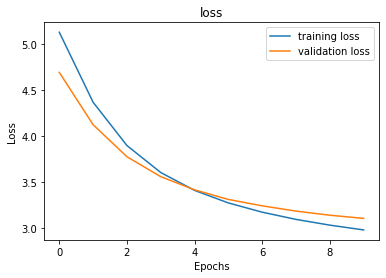


learning rate: 0.001
Epoch 0/9
----------
train Loss: 3.7296 Acc: 0.2328
val Loss: 3.1380 Acc: 0.3169

Epoch 1/9
----------
train Loss: 2.9407 Acc: 0.3478
val Loss: 2.9937 Acc: 0.3362

Epoch 2/9
----------
train Loss: 2.7705 Acc: 0.3742
val Loss: 2.9658 Acc: 0.3423

Epoch 3/9
----------
train Loss: 2.6782 Acc: 0.3900
val Loss: 2.9472 Acc: 0.3473

Epoch 4/9
----------
train Loss: 2.6187 Acc: 0.3997
val Loss: 2.9457 Acc: 0.3520

Epoch 5/9
----------
train Loss: 2.5702 Acc: 0.4066
val Loss: 2.9299 Acc: 0.3513

Epoch 6/9
----------
train Loss: 2.5349 Acc: 0.4118
val Loss: 2.9478 Acc: 0.3496

Epoch 7/9
----------
train Loss: 2.5070 Acc: 0.4184
val Loss: 2.9605 Acc: 0.3505

Epoch 8/9
----------
train Loss: 2.4801 Acc: 0.4222
val Loss: 2.9718 Acc: 0.3441

Epoch 9/9
----------
train Loss: 2.4573 Acc: 0.4275
val Loss: 2.9703 Acc: 0.3477

Training complete in 12m 57s
Best val Acc: 0.352000


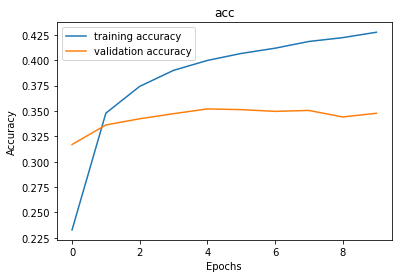

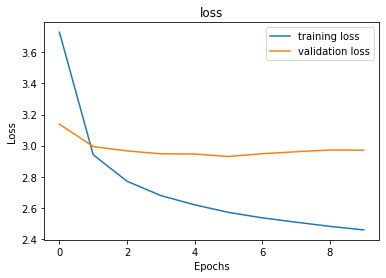


learning rate: 0.01
Epoch 0/9
----------
train Loss: 3.9003 Acc: 0.2574
val Loss: 3.6896 Acc: 0.2897

Epoch 1/9
----------
train Loss: 3.4864 Acc: 0.3161
val Loss: 3.8244 Acc: 0.2874

Epoch 2/9
----------
train Loss: 3.3890 Acc: 0.3294
val Loss: 3.8546 Acc: 0.2942

Epoch 3/9
----------
train Loss: 3.3674 Acc: 0.3370
val Loss: 4.0144 Acc: 0.2869

Epoch 4/9
----------
train Loss: 3.3488 Acc: 0.3423
val Loss: 4.0741 Acc: 0.2845

Epoch 5/9
----------
train Loss: 3.3792 Acc: 0.3431
val Loss: 4.1824 Acc: 0.2794

Epoch 6/9
----------
train Loss: 3.3528 Acc: 0.3465
val Loss: 4.2096 Acc: 0.2854

Epoch 7/9
----------
train Loss: 3.3430 Acc: 0.3494
val Loss: 4.2286 Acc: 0.2820

Epoch 8/9
----------
train Loss: 3.3619 Acc: 0.3504
val Loss: 4.2796 Acc: 0.2852

Epoch 9/9
----------
train Loss: 3.3504 Acc: 0.3508
val Loss: 4.2620 Acc: 0.2829

Training complete in 12m 59s
Best val Acc: 0.294200


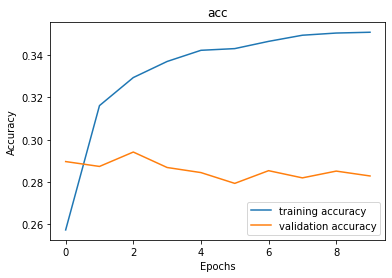

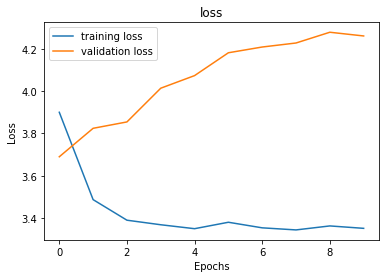


best validation accuracy tensor(0.3520, device='cuda:0', dtype=torch.float64)


In [24]:
# Fine tune only the last layer
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    model =models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
# torch.save(best_model.state_dict(), './models/resnet18_best_model_state_dict.pt')
print("best validation accuracy", max_acc)

##### Fine tune the whole layers

learning rate: 1e-05
Epoch 0/9
----------
train Loss: 5.3047 Acc: 0.0218
val Loss: 4.9067 Acc: 0.0560

Epoch 1/9
----------
train Loss: 4.5044 Acc: 0.1247
val Loss: 4.2171 Acc: 0.1740

Epoch 2/9
----------
train Loss: 3.8777 Acc: 0.2364
val Loss: 3.6950 Acc: 0.2565

Epoch 3/9
----------
train Loss: 3.4091 Acc: 0.3157
val Loss: 3.3180 Acc: 0.3167

Epoch 4/9
----------
train Loss: 3.0593 Acc: 0.3729
val Loss: 3.0483 Acc: 0.3549

Epoch 5/9
----------
train Loss: 2.7906 Acc: 0.4142
val Loss: 2.8423 Acc: 0.3864

Epoch 6/9
----------
train Loss: 2.5780 Acc: 0.4480
val Loss: 2.6893 Acc: 0.4057

Epoch 7/9
----------
train Loss: 2.4024 Acc: 0.4780
val Loss: 2.5710 Acc: 0.4250

Epoch 8/9
----------
train Loss: 2.2551 Acc: 0.5030
val Loss: 2.4699 Acc: 0.4390

Epoch 9/9
----------
train Loss: 2.1263 Acc: 0.5266
val Loss: 2.3958 Acc: 0.4537

Training complete in 53m 45s
Best val Acc: 0.453700


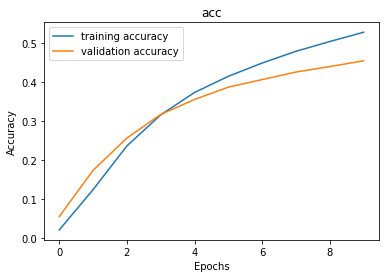

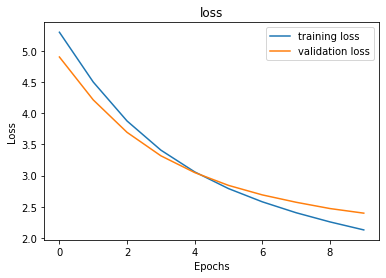


learning rate: 0.0001
Epoch 0/9
----------
train Loss: 3.4705 Acc: 0.2858
val Loss: 2.4543 Acc: 0.4358

Epoch 1/9
----------
train Loss: 1.9985 Acc: 0.5289
val Loss: 2.0711 Acc: 0.5077

Epoch 2/9
----------
train Loss: 1.4398 Acc: 0.6527
val Loss: 1.9785 Acc: 0.5287

Epoch 3/9
----------
train Loss: 0.9982 Acc: 0.7646
val Loss: 1.9423 Acc: 0.5332

Epoch 4/9
----------
train Loss: 0.6250 Acc: 0.8671
val Loss: 1.9968 Acc: 0.5307

Epoch 5/9
----------
train Loss: 0.3380 Acc: 0.9447
val Loss: 2.0594 Acc: 0.5230

Epoch 6/9
----------
train Loss: 0.1581 Acc: 0.9847
val Loss: 2.1234 Acc: 0.5266

Epoch 7/9
----------
train Loss: 0.0701 Acc: 0.9976
val Loss: 2.1645 Acc: 0.5230

Epoch 8/9
----------
train Loss: 0.0357 Acc: 0.9994
val Loss: 2.2071 Acc: 0.5253

Epoch 9/9
----------
train Loss: 0.0225 Acc: 0.9997
val Loss: 2.2417 Acc: 0.5211

Training complete in 53m 42s
Best val Acc: 0.533200


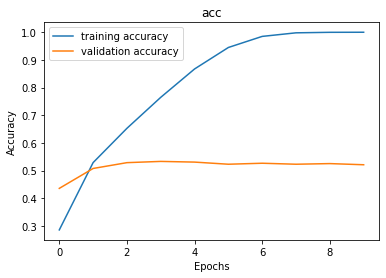

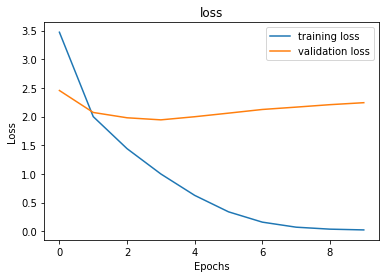


learning rate: 0.001
Epoch 0/9
----------
train Loss: 2.7477 Acc: 0.3568
val Loss: 2.6467 Acc: 0.3766

Epoch 1/9
----------
train Loss: 1.8411 Acc: 0.5358
val Loss: 2.4292 Acc: 0.4276

Epoch 2/9
----------
train Loss: 1.3338 Acc: 0.6484
val Loss: 2.3870 Acc: 0.4468

Epoch 3/9
----------
train Loss: 0.9115 Acc: 0.7467
val Loss: 2.5548 Acc: 0.4508

Epoch 4/9
----------
train Loss: 0.5946 Acc: 0.8286
val Loss: 2.8189 Acc: 0.4385

Epoch 5/9
----------
train Loss: 0.3744 Acc: 0.8895
val Loss: 2.9521 Acc: 0.4423

Epoch 6/9
----------
train Loss: 0.2646 Acc: 0.9192
val Loss: 3.1824 Acc: 0.4350

Epoch 7/9
----------
train Loss: 0.2151 Acc: 0.9334
val Loss: 3.4385 Acc: 0.4253

Epoch 8/9
----------
train Loss: 0.2035 Acc: 0.9365
val Loss: 3.5120 Acc: 0.4347

Epoch 9/9
----------
train Loss: 0.1855 Acc: 0.9412
val Loss: 3.5295 Acc: 0.4303

Training complete in 53m 41s
Best val Acc: 0.450800


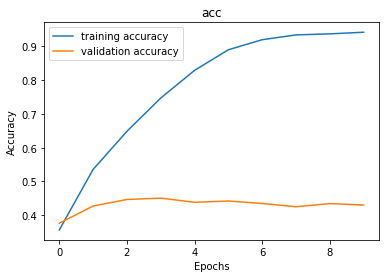

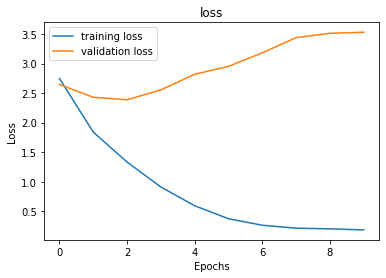


learning rate: 0.01
Epoch 0/9
----------
train Loss: 5.2464 Acc: 0.0135
val Loss: 4.9530 Acc: 0.0241

Epoch 1/9
----------
train Loss: 4.5817 Acc: 0.0550
val Loss: 4.5883 Acc: 0.0649

Epoch 2/9
----------
train Loss: 4.0019 Acc: 0.1264
val Loss: 4.4186 Acc: 0.0942

Epoch 3/9
----------
train Loss: 3.6317 Acc: 0.1786
val Loss: 4.0967 Acc: 0.1288

Epoch 4/9
----------
train Loss: 3.4095 Acc: 0.2168
val Loss: 4.3670 Acc: 0.1233

Epoch 5/9
----------
train Loss: 3.4298 Acc: 0.2194
val Loss: 7.2759 Acc: 0.0091

Epoch 6/9
----------
train Loss: 3.6480 Acc: 0.1870
val Loss: 4.0675 Acc: 0.1497

Epoch 7/9
----------
train Loss: 3.2268 Acc: 0.2512
val Loss: 3.8142 Acc: 0.1771

Epoch 8/9
----------
train Loss: 3.0823 Acc: 0.2779
val Loss: 3.5061 Acc: 0.2180

Epoch 9/9
----------
train Loss: 2.9179 Acc: 0.3057
val Loss: 3.4082 Acc: 0.2372

Training complete in 53m 20s
Best val Acc: 0.237200


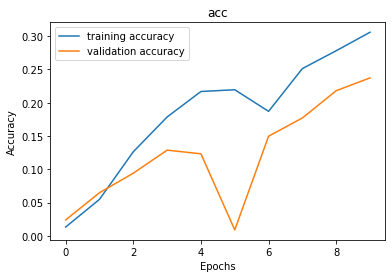

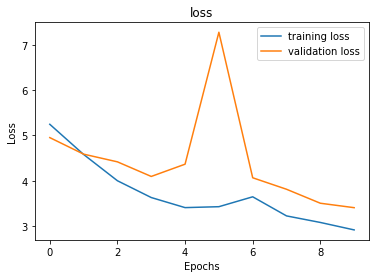


best validation accuracy tensor(0.5332, device='cuda:0', dtype=torch.float64)


In [25]:
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    model =models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
    model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
torch.save(best_model.state_dict(), './models/resnet18_best_model_state_dict.pt')
print("best validation accuracy", max_acc)

### Resnet152

##### Fine tune only the last layer

learning rate: 0.0001


Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 4.5261 Acc: 0.1736
val Loss: 3.8616 Acc: 0.3009

Epoch 1/9
----------
train Loss: 3.4815 Acc: 0.3358
val Loss: 3.2660 Acc: 0.3470

Epoch 2/9
----------
train Loss: 3.0640 Acc: 0.3723
val Loss: 3.0348 Acc: 0.3652

Epoch 3/9
----------
train Loss: 2.8599 Acc: 0.3908
val Loss: 2.9060 Acc: 0.3743

Epoch 4/9
----------
train Loss: 2.7350 Acc: 0.4042
val Loss: 2.8331 Acc: 0.3825

Epoch 5/9
----------
train Loss: 2.6482 Acc: 0.4136
val Loss: 2.7762 Acc: 0.3868

Epoch 6/9
----------
train Loss: 2.5814 Acc: 0.4237
val Loss: 2.7383 Acc: 0.3927

Epoch 7/9
----------
train Loss: 2.5287 Acc: 0.4305
val Loss: 2.7179 Acc: 0.3934

Epoch 8/9
----------
train Loss: 2.4850 Acc: 0.4365
val Loss: 2.6957 Acc: 0.3956

Epoch 9/9
----------
train Loss: 2.4480 Acc: 0.4430
val Loss: 2.6829 Acc: 0.3975

Training complete in 39m 51s
Best val Acc: 0.397500


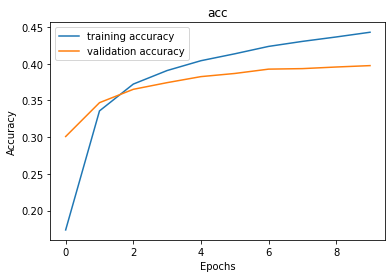

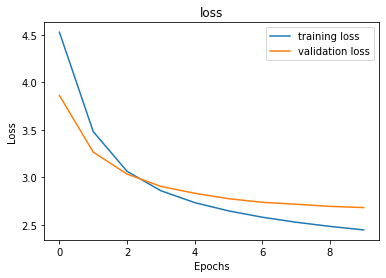


learning rate: 0.001


Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 3.1854 Acc: 0.3196
val Loss: 2.7639 Acc: 0.3794

Epoch 1/9
----------
train Loss: 2.5451 Acc: 0.4150
val Loss: 2.7041 Acc: 0.3912

Epoch 2/9
----------
train Loss: 2.3812 Acc: 0.4443
val Loss: 2.6842 Acc: 0.3948

Epoch 3/9
----------
train Loss: 2.2679 Acc: 0.4648
val Loss: 2.6857 Acc: 0.3980

Epoch 4/9
----------
train Loss: 2.1796 Acc: 0.4819
val Loss: 2.6623 Acc: 0.4033

Epoch 5/9
----------
train Loss: 2.1079 Acc: 0.4938
val Loss: 2.6788 Acc: 0.4013

Epoch 6/9
----------
train Loss: 2.0410 Acc: 0.5078
val Loss: 2.6716 Acc: 0.4019

Epoch 7/9
----------
train Loss: 1.9796 Acc: 0.5196
val Loss: 2.6766 Acc: 0.4032

Epoch 8/9
----------
train Loss: 1.9311 Acc: 0.5292
val Loss: 2.6864 Acc: 0.4057

Epoch 9/9
----------
train Loss: 1.8788 Acc: 0.5419
val Loss: 2.6724 Acc: 0.4069

Training complete in 39m 52s
Best val Acc: 0.406900


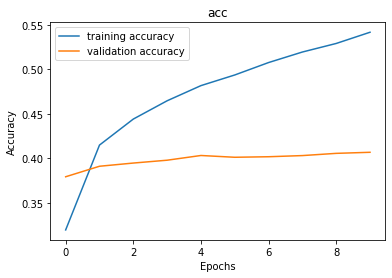

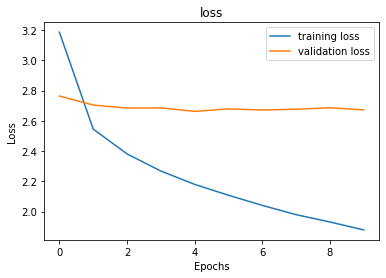


learning rate: 0.01


Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 4.9451 Acc: 0.2776
val Loss: 4.1404 Acc: 0.3164

Epoch 1/9
----------
train Loss: 3.7442 Acc: 0.3541
val Loss: 4.3905 Acc: 0.3232

Epoch 2/9
----------
train Loss: 3.5282 Acc: 0.3852
val Loss: 4.5885 Acc: 0.3264

Epoch 3/9
----------
train Loss: 3.3740 Acc: 0.4079
val Loss: 4.8140 Acc: 0.3219

Epoch 4/9
----------
train Loss: 3.2256 Acc: 0.4293
val Loss: 4.8266 Acc: 0.3277

Epoch 5/9
----------
train Loss: 3.0397 Acc: 0.4510
val Loss: 4.8201 Acc: 0.3370

Epoch 6/9
----------
train Loss: 2.9101 Acc: 0.4648
val Loss: 4.9337 Acc: 0.3313

Epoch 7/9
----------
train Loss: 2.8058 Acc: 0.4818
val Loss: 5.2000 Acc: 0.3336

Epoch 8/9
----------
train Loss: 2.7498 Acc: 0.4912
val Loss: 5.1537 Acc: 0.3376

Epoch 9/9
----------
train Loss: 2.6666 Acc: 0.5024
val Loss: 5.3169 Acc: 0.3354

Training complete in 39m 56s
Best val Acc: 0.337600


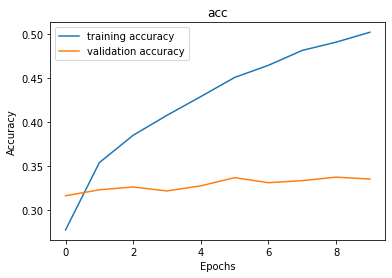

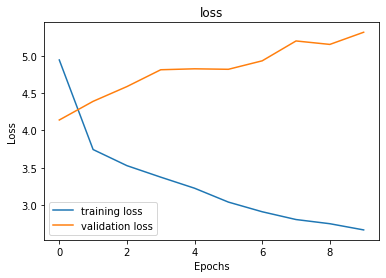


learning rate: 0.1


Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 55.3392 Acc: 0.2332
val Loss: 31.3727 Acc: 0.2777

Epoch 1/9
----------
train Loss: 30.4141 Acc: 0.3057
val Loss: 35.4435 Acc: 0.2864

Epoch 2/9
----------
train Loss: 29.2076 Acc: 0.3370
val Loss: 36.8228 Acc: 0.2981

Epoch 3/9
----------
train Loss: 29.0422 Acc: 0.3595
val Loss: 38.3192 Acc: 0.3008

Epoch 4/9
----------
train Loss: 28.1637 Acc: 0.3799
val Loss: 40.4473 Acc: 0.3049

Epoch 5/9
----------
train Loss: 27.2671 Acc: 0.4016
val Loss: 42.5242 Acc: 0.3052

Epoch 6/9
----------
train Loss: 27.4189 Acc: 0.4091
val Loss: 45.8933 Acc: 0.3093

Epoch 7/9
----------
train Loss: 26.3396 Acc: 0.4292
val Loss: 44.3333 Acc: 0.3167

Epoch 8/9
----------
train Loss: 26.2949 Acc: 0.4382
val Loss: 45.7676 Acc: 0.3121

Epoch 9/9
----------
train Loss: 26.0381 Acc: 0.4477
val Loss: 47.9294 Acc: 0.3114

Training complete in 40m 10s
Best val Acc: 0.316700


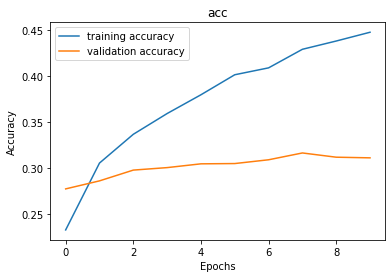

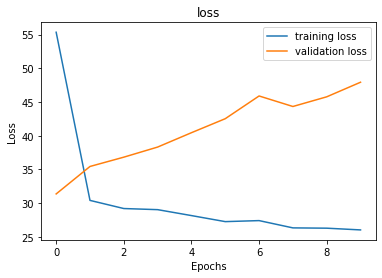


best validation accuracy tensor(0.4069, device='cuda:0', dtype=torch.float64)


In [17]:
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
# torch.save(best_model.state_dict(), './models/resnet152_best_model_state_dict.pt')
print("best validation accuracy", max_acc)

##### Fine tune the whole layers

learning rate: 1e-05


Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 4.9465 Acc: 0.0839
val Loss: 4.3327 Acc: 0.2313

Epoch 1/9
----------
train Loss: 3.6818 Acc: 0.3381
val Loss: 3.1288 Acc: 0.4045

Epoch 2/9
----------
train Loss: 2.6324 Acc: 0.4850
val Loss: 2.4095 Acc: 0.5015

Epoch 3/9
----------
train Loss: 1.9699 Acc: 0.5878
val Loss: 2.0486 Acc: 0.5462

Epoch 4/9
----------
train Loss: 1.5214 Acc: 0.6698
val Loss: 1.8822 Acc: 0.5649

Epoch 5/9
----------
train Loss: 1.1824 Acc: 0.7398
val Loss: 1.8053 Acc: 0.5743

Epoch 6/9
----------
train Loss: 0.9100 Acc: 0.8008
val Loss: 1.7749 Acc: 0.5804

Epoch 7/9
----------
train Loss: 0.6866 Acc: 0.8544
val Loss: 1.7855 Acc: 0.5786

Epoch 8/9
----------
train Loss: 0.5205 Acc: 0.8981
val Loss: 1.7866 Acc: 0.5777

Epoch 9/9
----------
train Loss: 0.4965 Acc: 0.9037
val Loss: 1.7904 Acc: 0.5778

Training complete in 197m 12s
Best val Acc: 0.580400


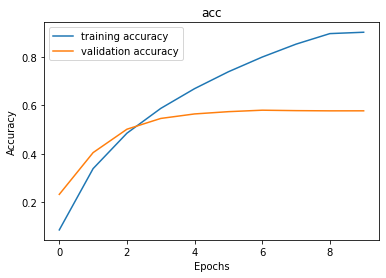

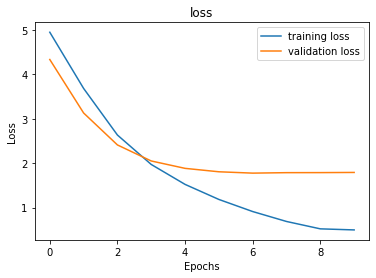


learning rate: 0.0001


Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 2.6064 Acc: 0.4499
val Loss: 1.6384 Acc: 0.6032

Epoch 1/9
----------
train Loss: 1.0813 Acc: 0.7291
val Loss: 1.5102 Acc: 0.6218

Epoch 2/9
----------
train Loss: 0.4899 Acc: 0.8769
val Loss: 1.5436 Acc: 0.6346

Epoch 3/9
----------
train Loss: 0.1996 Acc: 0.9520
val Loss: 1.6644 Acc: 0.6310

Epoch 4/9
----------


In [ ]:
# Fine tune the whole layers
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
torch.save(best_model.state_dict(), './models/resnet152_best_model_state_dict.pt')
print("best validation accuracy", max_acc)

learning rate: 0.0001


Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 2.5959 Acc: 0.4472
val Loss: 1.6407 Acc: 0.5954

Epoch 1/9
----------
train Loss: 1.0887 Acc: 0.7272
val Loss: 1.5100 Acc: 0.6238

Epoch 2/9
----------
train Loss: 0.4900 Acc: 0.8761
val Loss: 1.5446 Acc: 0.6306

Epoch 3/9
----------
train Loss: 0.1971 Acc: 0.9539
val Loss: 1.6339 Acc: 0.6307

Epoch 4/9
----------
train Loss: 0.0792 Acc: 0.9828
val Loss: 1.7525 Acc: 0.6332

Epoch 5/9
----------
train Loss: 0.0339 Acc: 0.9938
val Loss: 1.7763 Acc: 0.6320

Epoch 6/9
----------
train Loss: 0.0194 Acc: 0.9963
val Loss: 1.8588 Acc: 0.6329

Epoch 7/9
----------
train Loss: 0.0226 Acc: 0.9952
val Loss: 1.9862 Acc: 0.6181

Epoch 8/9
----------
train Loss: 0.0159 Acc: 0.9970
val Loss: 1.8674 Acc: 0.6372

Epoch 9/9
----------
train Loss: 0.0046 Acc: 0.9997
val Loss: 1.8635 Acc: 0.6400

Training complete in 172m 26s
Best val Acc: 0.640000


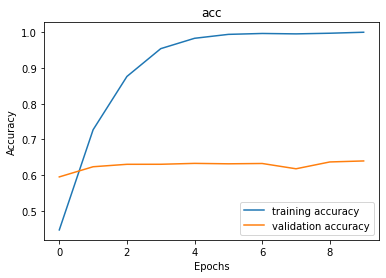

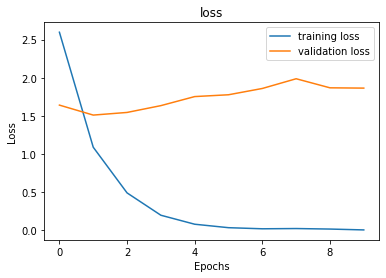


learning rate: 0.001


Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 2.8499 Acc: 0.3341
val Loss: 2.5990 Acc: 0.3794

Epoch 1/9
----------
train Loss: 1.9262 Acc: 0.5134
val Loss: 2.3922 Acc: 0.4270

Epoch 2/9
----------
train Loss: 1.4430 Acc: 0.6190
val Loss: 2.2328 Acc: 0.4669

Epoch 3/9
----------
train Loss: 1.0732 Acc: 0.7060
val Loss: 2.3012 Acc: 0.4721

Epoch 4/9
----------
train Loss: 0.7840 Acc: 0.7762
val Loss: 2.3548 Acc: 0.4849

Epoch 5/9
----------
train Loss: 0.5705 Acc: 0.8310
val Loss: 2.6819 Acc: 0.4686

Epoch 6/9
----------
train Loss: 0.4158 Acc: 0.8728
val Loss: 2.7344 Acc: 0.4696

Epoch 7/9
----------
train Loss: 0.3114 Acc: 0.9036
val Loss: 2.8706 Acc: 0.4648

Epoch 8/9
----------
train Loss: 0.0928 Acc: 0.9754
val Loss: 2.4740 Acc: 0.5351

Epoch 9/9
----------
train Loss: 0.0170 Acc: 0.9991
val Loss: 2.5485 Acc: 0.5364

Training complete in 171m 48s
Best val Acc: 0.536400


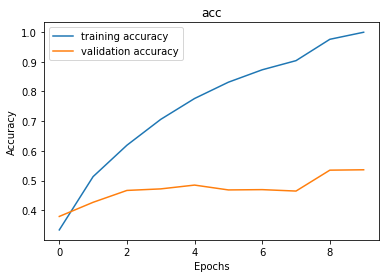

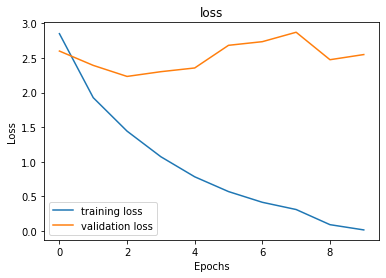


learning rate: 0.01


Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 5.3323 Acc: 0.0082
val Loss: 5.2753 Acc: 0.0182

Epoch 1/9
----------
train Loss: 4.9406 Acc: 0.0274
val Loss: 4.8077 Acc: 0.0369

Epoch 2/9
----------
train Loss: 4.5055 Acc: 0.0667
val Loss: 9.3885 Acc: 0.0797

Epoch 3/9
----------
train Loss: 4.0066 Acc: 0.1266
val Loss: 2172.1948 Acc: 0.0787

Epoch 4/9
----------
train Loss: 3.6179 Acc: 0.1864
val Loss: 4.5548 Acc: 0.1831

Epoch 5/9
----------
train Loss: 3.3663 Acc: 0.2284
val Loss: 3.7421 Acc: 0.1879

Epoch 6/9
----------
train Loss: 3.2294 Acc: 0.2547
val Loss: 3.5269 Acc: 0.2212

Epoch 7/9
----------
train Loss: 3.0592 Acc: 0.2823
val Loss: 4.1694 Acc: 0.1673

Epoch 8/9
----------
train Loss: 2.6551 Acc: 0.3623
val Loss: 3.4942 Acc: 0.3128

Epoch 9/9
----------
train Loss: 2.5176 Acc: 0.3875
val Loss: 3.4447 Acc: 0.3199

Training complete in 171m 8s
Best val Acc: 0.319900


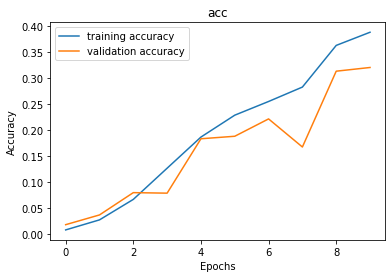

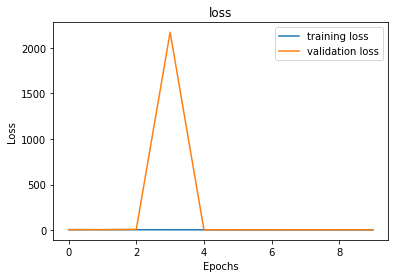


best validation accuracy tensor(0.6400, device='cuda:0', dtype=torch.float64)


In [5]:
# Fine tune the whole layers
learning_rates = [1e-4, 1e-3, 1e-2]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet152', pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
torch.save(best_model.state_dict(), './models/resnet152_best_model_state_dict.pt')
print("best validation accuracy", max_acc)

### VGG11_bn model

In [18]:
vgg_model = models.vgg11_bn(pretrained=True)
for param in vgg_model.parameters():
    param.requires_grad = False
num_ftrs = vgg_model.classifier[6].in_features
vgg_model.classifier[6] = nn.Linear(num_ftrs,num_classes)
vgg_model.eval()
# for param in vgg_model.parameters():
#     print(param.requires_grad)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

##### Fine tune the last layer

learning rate: 0.0001
Epoch 0/9
----------
train Loss: 4.0349 Acc: 0.2152
val Loss: 3.2275 Acc: 0.3574

Epoch 1/9
----------
train Loss: 3.0010 Acc: 0.3564
val Loss: 2.8061 Acc: 0.3923

Epoch 2/9
----------
train Loss: 2.7291 Acc: 0.3848
val Loss: 2.6534 Acc: 0.4025

Epoch 3/9
----------
train Loss: 2.5984 Acc: 0.4021
val Loss: 2.5703 Acc: 0.4144

Epoch 4/9
----------
train Loss: 2.5161 Acc: 0.4144
val Loss: 2.5142 Acc: 0.4181

Epoch 5/9
----------
train Loss: 2.4547 Acc: 0.4239
val Loss: 2.4811 Acc: 0.4239

Epoch 6/9
----------
train Loss: 2.4075 Acc: 0.4315
val Loss: 2.4521 Acc: 0.4241

Epoch 7/9
----------
train Loss: 2.3653 Acc: 0.4408
val Loss: 2.4538 Acc: 0.4253

Epoch 8/9
----------
train Loss: 2.3594 Acc: 0.4413
val Loss: 2.4504 Acc: 0.4262

Epoch 9/9
----------
train Loss: 2.3537 Acc: 0.4419
val Loss: 2.4463 Acc: 0.4266

Training complete in 56m 8s
Best val Acc: 0.426600


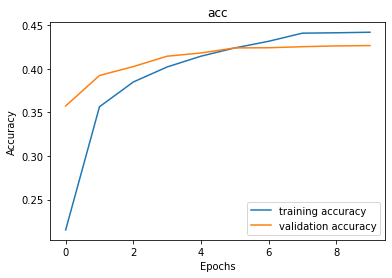

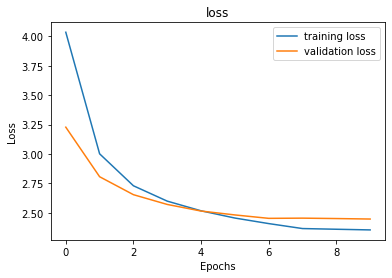


learning rate: 0.001
Epoch 0/9
----------
train Loss: 2.9334 Acc: 0.3426
val Loss: 2.4772 Acc: 0.4166

Epoch 1/9
----------
train Loss: 2.4910 Acc: 0.4117
val Loss: 2.4322 Acc: 0.4273

Epoch 2/9
----------
train Loss: 2.3819 Acc: 0.4297
val Loss: 2.4162 Acc: 0.4315

Epoch 3/9
----------
train Loss: 2.3166 Acc: 0.4406
val Loss: 2.4037 Acc: 0.4366

Epoch 4/9
----------
train Loss: 2.2732 Acc: 0.4496
val Loss: 2.3888 Acc: 0.4379

Epoch 5/9
----------
train Loss: 2.2419 Acc: 0.4539
val Loss: 2.4081 Acc: 0.4370

Epoch 6/9
----------
train Loss: 2.2160 Acc: 0.4584
val Loss: 2.4178 Acc: 0.4409

Epoch 7/9
----------
train Loss: 2.0463 Acc: 0.4885
val Loss: 2.3615 Acc: 0.4467

Epoch 8/9
----------
train Loss: 2.0154 Acc: 0.4942
val Loss: 2.3488 Acc: 0.4481

Epoch 9/9
----------
train Loss: 2.0082 Acc: 0.4975
val Loss: 2.3436 Acc: 0.4469

Training complete in 56m 34s
Best val Acc: 0.448100


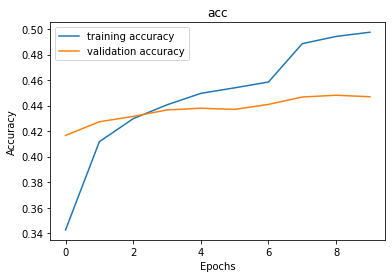

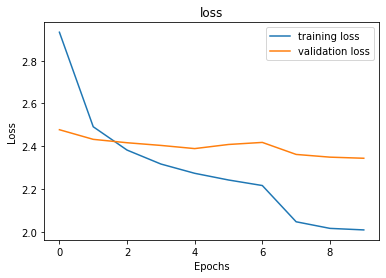


learning rate: 0.01
Epoch 0/9
----------
train Loss: 6.5293 Acc: 0.2679
val Loss: 5.3259 Acc: 0.3560

Epoch 1/9
----------
train Loss: 7.2021 Acc: 0.3117
val Loss: 6.0124 Acc: 0.3740

Epoch 2/9
----------
train Loss: 7.6590 Acc: 0.3297
val Loss: 6.3962 Acc: 0.3809

Epoch 3/9
----------
train Loss: 7.9419 Acc: 0.3405
val Loss: 6.8450 Acc: 0.3782

Epoch 4/9
----------
train Loss: 8.1958 Acc: 0.3471
val Loss: 7.2411 Acc: 0.3853

Epoch 5/9
----------
train Loss: 8.4046 Acc: 0.3525
val Loss: 7.3723 Acc: 0.3901

Epoch 6/9
----------
train Loss: 8.5217 Acc: 0.3611
val Loss: 7.4077 Acc: 0.3918

Epoch 7/9
----------
train Loss: 7.0595 Acc: 0.4048
val Loss: 6.3005 Acc: 0.4229

Epoch 8/9
----------
train Loss: 6.4815 Acc: 0.4163
val Loss: 6.0394 Acc: 0.4302

Epoch 9/9
----------
train Loss: 6.2334 Acc: 0.4185
val Loss: 5.8579 Acc: 0.4325

Training complete in 56m 48s
Best val Acc: 0.432500
train Loss: 60.9892 Acc: 0.2474
val Loss: 49.5724 Acc: 0.3482

Epoch 1/9
----------
train Loss: 69.6755 Acc

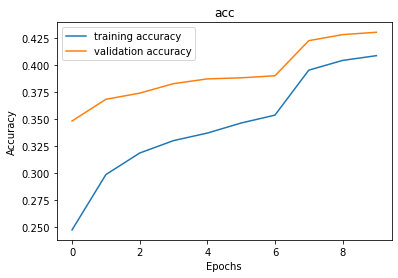

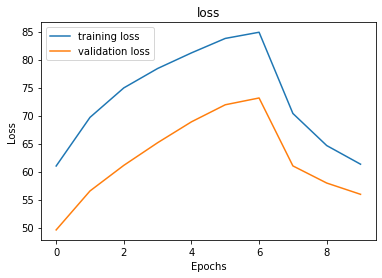


best validation accuracy tensor(0.4481, device='cuda:0', dtype=torch.float64)


In [19]:
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    vgg_model = models.vgg11_bn(pretrained=True)
    for param in vgg_model.parameters():
        param.requires_grad = False
    num_ftrs = vgg_model.classifier[6].in_features
    vgg_model.classifier[6] = nn.Linear(num_ftrs,num_classes)
    vgg_model = vgg_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, vgg_model.parameters()), lr=lr)
    # optimizer_ft = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    vgg_model, tr_acc, val_acc, tr_loss, val_loss = train_model(vgg_model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = vgg_model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
torch.save(best_model, './models/vgg11_bn_best_model.pt')
print("best validation accuracy", max_acc)

##### Fine tune the whole layers

In [ ]:
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    vgg_model = models.vgg11_bn(pretrained=True)
#     for param in vgg_model.parameters():
#         param.requires_grad = False
    num_ftrs = vgg_model.classifier[6].in_features
    vgg_model.classifier[6] = nn.Linear(num_ftrs,num_classes)
    vgg_model = vgg_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, vgg_model.parameters()), lr=lr)
    # optimizer_ft = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    vgg_model, tr_acc, val_acc, tr_loss, val_loss = train_model(vgg_model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = vgg_model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
torch.save(best_model.state_dict(), './models/vgg11_bn_best_model_state_dict.pt')
print("best validation accuracy", max_acc)

##### VGG19_bn

##### fine tune the last layer

In [18]:
%%capture output2
learning_rates = [1e-5, 1e-4, 1e-3]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    vgg_model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19_bn', pretrained=True)
    for param in vgg_model.parameters():
        param.requires_grad = False
    num_ftrs = vgg_model.classifier[6].in_features
    vgg_model.classifier[6] = nn.Linear(num_ftrs,num_classes)
    vgg_model = vgg_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, vgg_model.parameters()), lr=lr)
    # optimizer_ft = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    vgg_model, tr_acc, val_acc, tr_loss, val_loss = train_model(vgg_model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = vgg_model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
print("best validation accuracy", max_acc)
output2.show()

KeyboardInterrupt: 

learning rate: 1e-05
Epoch 0/9
----------
train Loss: 5.2292 Acc: 0.0164
val Loss: 5.0091 Acc: 0.0668

Epoch 1/9
----------
train Loss: 4.9088 Acc: 0.0656
val Loss: 4.7205 Acc: 0.1740

Epoch 2/9
----------
train Loss: 4.6333 Acc: 0.1316
val Loss: 4.4746 Acc: 0.2304

Epoch 3/9
----------
train Loss: 4.3980 Acc: 0.1872
val Loss: 4.2597 Acc: 0.2656

Epoch 4/9
----------
train Loss: 4.1996 Acc: 0.2243
val Loss: 4.0883 Acc: 0.2826

Epoch 5/9
----------
train Loss: 4.0314 Acc: 0.2483
val Loss: 3.9321 Acc: 0.2962

Epoch 6/9
----------
train Loss: 3.8840 Acc: 0.2674
val Loss: 3.7831 Acc: 0.3057

Epoch 7/9
----------
train Loss: 3.7619 Acc: 0.2797
val Loss: 3.6868 Acc: 0.3122

Epoch 8/9
----------
train Loss: 3.7007 Acc: 0.2872
val Loss: 3.6708 Acc: 0.3126

Epoch 9/9
----------
train Loss: 3.6867 Acc: 0.2901
val Loss: 3.6699 Acc: 0.3134

Training complete in 177m 28s
Best val Acc: 0.313400

learning rate: 0.0001
Epoch 0/9
----------
train Loss: 4.2242 Acc: 0.1956
val Loss: 3.4802 Acc: 0.3201

E

Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.6.0
Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.6.0


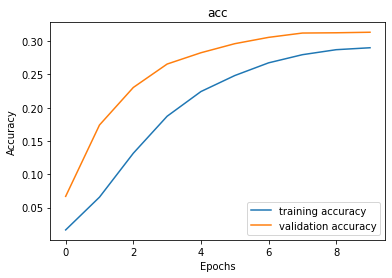

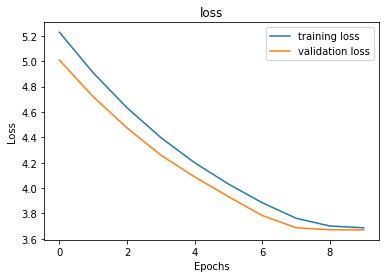

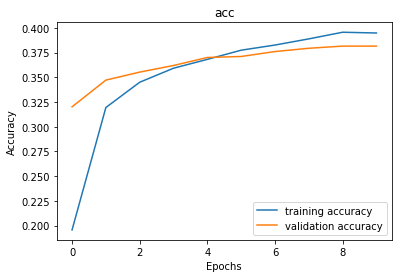

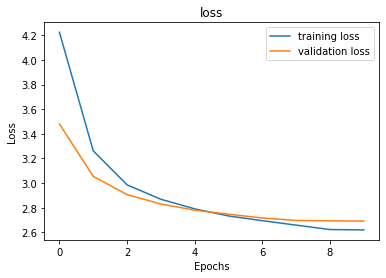

In [22]:
output2.show()

##### fine tune the whole layers

learning rate: 0.0001


Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 2.6223 Acc: 0.4034
val Loss: 1.7254 Acc: 0.5688

Epoch 1/9
----------
train Loss: 1.3703 Acc: 0.6488
val Loss: 1.6020 Acc: 0.6012

Epoch 2/9
----------
train Loss: 0.8587 Acc: 0.7695
val Loss: 1.6663 Acc: 0.6108

Epoch 3/9
----------
train Loss: 0.5215 Acc: 0.8544
val Loss: 1.8178 Acc: 0.6084

Epoch 4/9
----------
train Loss: 0.3302 Acc: 0.9039
val Loss: 2.0106 Acc: 0.6039

Epoch 5/9
----------
train Loss: 0.2225 Acc: 0.9337
val Loss: 2.2225 Acc: 0.5980

Epoch 6/9
----------
train Loss: 0.1689 Acc: 0.9481
val Loss: 2.3782 Acc: 0.5943

Epoch 7/9
----------
train Loss: 0.1344 Acc: 0.9589
val Loss: 2.4786 Acc: 0.5956

Epoch 8/9
----------
train Loss: 0.0579 Acc: 0.9835
val Loss: 2.4752 Acc: 0.6162

Epoch 9/9
----------
train Loss: 0.0245 Acc: 0.9939
val Loss: 2.6086 Acc: 0.6170

Training complete in 530m 3s
Best val Acc: 0.617000


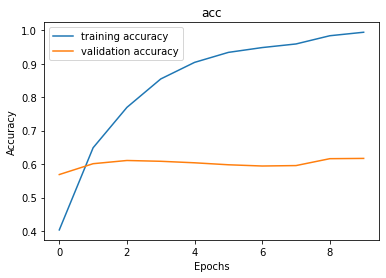

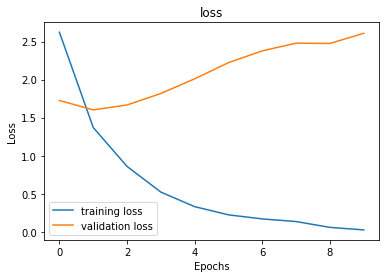


best validation accuracy tensor(0.6170, dtype=torch.float64)


In [17]:
# %%capture output

learning_rates = [1e-4]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    vgg_model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19_bn', pretrained=True)
#     for param in vgg_model.parameters():
#         param.requires_grad = False
    num_ftrs = vgg_model.classifier[6].in_features
    vgg_model.classifier[6] = nn.Linear(num_ftrs,num_classes)
    vgg_model = vgg_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, vgg_model.parameters()), lr=lr)
    # optimizer_ft = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    vgg_model, tr_acc, val_acc, tr_loss, val_loss = train_model(vgg_model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = vgg_model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
    
torch.save(best_model.state_dict(), './models/vgg19_bn_best_model_state_dict.pt')
torch.save(tr_loss, './models/vgg19_tr_loss.pt')
torch.save(tr_acc, './models/vgg19_tr_acc.pt')
torch.save(val_loss, './models/vgg19_val_loss.pt')
torch.save(val_acc, './models/vgg19_val_acc.pt')
print("best validation accuracy", max_acc)
# output.show()

##### train with data augmentation

learning rate: 0.0001


Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_vision_v0.6.0


Epoch 0/9
----------
train Loss: 3.5437 Acc: 0.2286
val Loss: 2.1806 Acc: 0.4644

Epoch 1/9
----------
train Loss: 2.4428 Acc: 0.4123
val Loss: 1.9286 Acc: 0.5264

Epoch 2/9
----------
train Loss: 2.1556 Acc: 0.4709
val Loss: 1.8460 Acc: 0.5372

Epoch 3/9
----------
train Loss: 1.9749 Acc: 0.5087
val Loss: 1.7401 Acc: 0.5677

Epoch 4/9
----------
train Loss: 1.8399 Acc: 0.5388
val Loss: 1.7198 Acc: 0.5710

Epoch 5/9
----------
train Loss: 1.7347 Acc: 0.5618
val Loss: 1.6512 Acc: 0.5879

Epoch 6/9
----------
train Loss: 1.6358 Acc: 0.5829
val Loss: 1.6385 Acc: 0.5922

Epoch 7/9
----------
train Loss: 1.5542 Acc: 0.6019
val Loss: 1.6441 Acc: 0.5885

Epoch 8/9
----------
train Loss: 1.3763 Acc: 0.6399
val Loss: 1.5547 Acc: 0.6154

Epoch 9/9
----------
train Loss: 1.3196 Acc: 0.6541
val Loss: 1.5435 Acc: 0.6172

Training complete in 530m 34s
Best val Acc: 0.617200


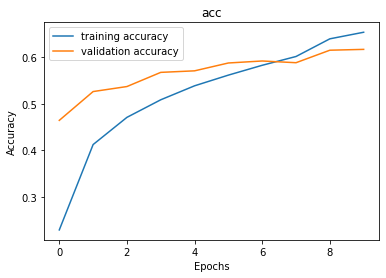

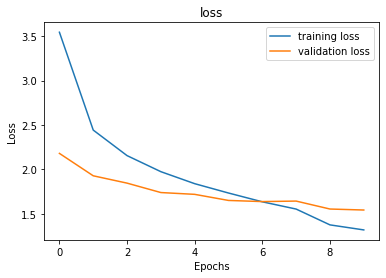


best validation accuracy tensor(0.6172, dtype=torch.float64)


In [5]:
# %%capture output

learning_rates = [1e-4]
max_acc = 0
num_e = 10

for lr in learning_rates:
    print("learning rate:", lr)
    image_datasets, dataloaders, dataset_sizes, class_names = load_data(500, data_aug=True)
    vgg_model = torch.hub.load('pytorch/vision:v0.6.0', 'vgg19_bn', pretrained=True)
#     for param in vgg_model.parameters():
#         param.requires_grad = False
    num_ftrs = vgg_model.classifier[6].in_features
    vgg_model.classifier[6] = nn.Linear(num_ftrs,num_classes)
    vgg_model = vgg_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, vgg_model.parameters()), lr=lr)
    # optimizer_ft = optim.SGD(vgg_model.parameters(), lr=0.01, momentum=0.9)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    vgg_model, tr_acc, val_acc, tr_loss, val_loss = train_model(vgg_model, criterion, optimizer_ft, scheduler, num_epochs=num_e)
    if max(val_acc) > max_acc:
        best_model = vgg_model
        max_acc = max(val_acc)

    plot_result(range(num_e), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(num_e), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
    
torch.save(best_model.state_dict(), './models/vgg19_bn_best_model_with_dataaug_state_dict.pt')
torch.save(tr_loss, './models/vgg19_tr_loss_dataaug.pt')
torch.save(tr_acc, './models/vgg19_tr_acc_dataaug.pt')
torch.save(val_loss, './models/vgg19_val_loss_dataaug.pt')
torch.save(val_acc, './models/vgg19_val_acc_dataaug.pt')
print("best validation accuracy", max_acc)
# output.show()

### squeezenet

In [ ]:
inc_model = torch.hub.load('pytorch/vision:v0.5.0', 'squeezenet1_0', pretrained=True)
inc_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
inc_model.eval()

In [7]:
inc_model = torch.hub.load('pytorch/vision:v0.5.0', 'squeezenet1_0', pretrained=True)
inc_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
inc_model.eval()

Using cache found in /home/watanabekeisuke/.cache/torch/hub/pytorch_vision_v0.5.0


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
inc_model = inc_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(inc_model.parameters(), lr=0.0001)
optimizer_ft = optim.SGD(inc_model.parameters(), lr=0.01, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
inc_model, inc_tr_acc, inc_val_acc, inc_tr_loss, inc_val_loss = train_model(inc_model, criterion, optimizer_ft, scheduler, num_epochs=10)

Epoch 0/9
----------


### densenet

In [8]:
dense_model = torchvision.models.densenet169(pretrained=True)

In [9]:
for param in dense_model.parameters():
    param.requires_grad = False
num_ftrs = dense_model.classifier.in_features
dense_model.classifier = nn.Linear(num_ftrs, num_classes)
dense_model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [10]:
dense_model = dense_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, dense_model.parameters()), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
dense_model, tr_acc, val_acc, tr_loss, val_loss = train_model(dense_model, criterion, optimizer_ft, scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 3.2805 Acc: 0.3267
val Loss: 2.6901 Acc: 0.4112

Epoch 1/9
----------
train Loss: 2.3874 Acc: 0.4598
val Loss: 2.5411 Acc: 0.4316

Epoch 2/9
----------
train Loss: 2.1652 Acc: 0.4975
val Loss: 2.5113 Acc: 0.4321

Epoch 3/9
----------
train Loss: 2.0360 Acc: 0.5205
val Loss: 2.5251 Acc: 0.4307

Epoch 4/9
----------
train Loss: 1.9467 Acc: 0.5365
val Loss: 2.5328 Acc: 0.4309

Epoch 5/9
----------
train Loss: 1.8799 Acc: 0.5475
val Loss: 2.5435 Acc: 0.4301

Epoch 6/9
----------
train Loss: 1.8294 Acc: 0.5586
val Loss: 2.5770 Acc: 0.4260

Epoch 7/9
----------
train Loss: 1.6832 Acc: 0.5946
val Loss: 2.5414 Acc: 0.4330

Epoch 8/9
----------
train Loss: 1.6717 Acc: 0.5981
val Loss: 2.5461 Acc: 0.4327

Epoch 9/9
----------
train Loss: 1.6669 Acc: 0.5984
val Loss: 2.5485 Acc: 0.4332

Training complete in 56m 22s
Best val Acc: 0.433200


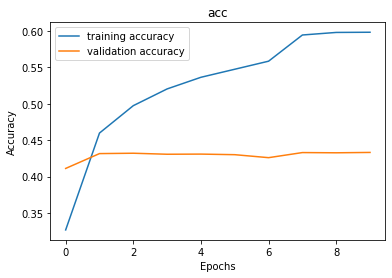

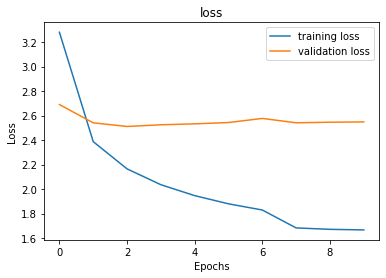

In [11]:
torch.save(dense_model.state_dict(), './models/dense169_model_state_dict.pt')
plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')

##### Fine tune only the last layer

train Loss: 5.3794 Acc: 0.0068
val Loss: 5.3066 Acc: 0.0101

Epoch 1/9
----------
train Loss: 5.2296 Acc: 0.0149
val Loss: 5.1715 Acc: 0.0208

Epoch 2/9
----------
train Loss: 5.0984 Acc: 0.0288
val Loss: 5.0457 Acc: 0.0364

Epoch 3/9
----------
train Loss: 4.9739 Acc: 0.0486
val Loss: 4.9282 Acc: 0.0584

Epoch 4/9
----------
train Loss: 4.8567 Acc: 0.0737
val Loss: 4.8165 Acc: 0.0831

Epoch 5/9
----------
train Loss: 4.7434 Acc: 0.1003
val Loss: 4.7061 Acc: 0.1081

Epoch 6/9
----------
train Loss: 4.6359 Acc: 0.1274
val Loss: 4.6080 Acc: 0.1339

Epoch 7/9
----------
train Loss: 4.5325 Acc: 0.1547
val Loss: 4.5134 Acc: 0.1576

Epoch 8/9
----------
train Loss: 4.4756 Acc: 0.1680
val Loss: 4.4975 Acc: 0.1604

Epoch 9/9
----------
train Loss: 4.4652 Acc: 0.1712
val Loss: 4.4920 Acc: 0.1621

Training complete in 24m 5s
Best val Acc: 0.162100


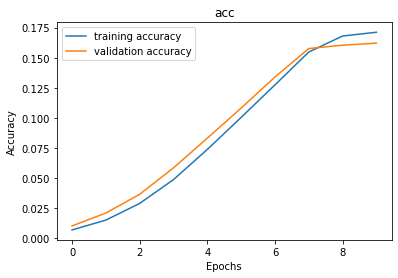

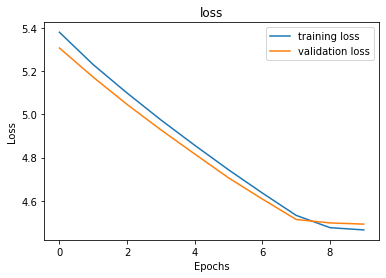


learning rate: 0.0001
Epoch 0/9
----------
train Loss: 4.8379 Acc: 0.0880
val Loss: 4.3198 Acc: 0.1981

Epoch 1/9
----------
train Loss: 3.9472 Acc: 0.2768
val Loss: 3.6911 Acc: 0.3130

Epoch 2/9
----------
train Loss: 3.4416 Acc: 0.3534
val Loss: 3.3369 Acc: 0.3587

Epoch 3/9
----------
train Loss: 3.1331 Acc: 0.3900
val Loss: 3.1177 Acc: 0.3791

Epoch 4/9
----------
train Loss: 2.9278 Acc: 0.4137
val Loss: 2.9765 Acc: 0.3929

Epoch 5/9
----------
train Loss: 2.7796 Acc: 0.4289
val Loss: 2.8677 Acc: 0.4037

Epoch 6/9
----------
train Loss: 2.6678 Acc: 0.4409
val Loss: 2.7940 Acc: 0.4099

Epoch 7/9
----------
train Loss: 2.5782 Acc: 0.4524
val Loss: 2.7329 Acc: 0.4130

Epoch 8/9
----------
train Loss: 2.5208 Acc: 0.4618
val Loss: 2.7356 Acc: 0.4131

Epoch 9/9
----------
train Loss: 2.5135 Acc: 0.4623
val Loss: 2.7228 Acc: 0.4156

Training complete in 24m 1s
Best val Acc: 0.415600


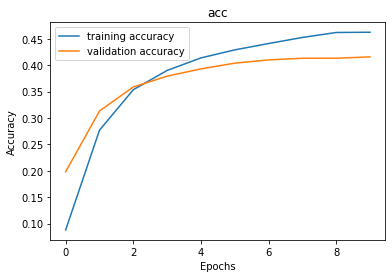

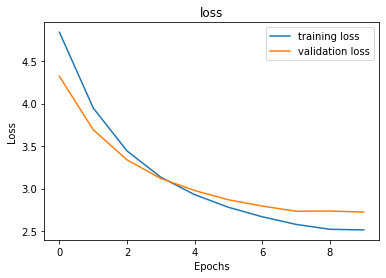


learning rate: 0.001
Epoch 0/9
----------
train Loss: 3.2795 Acc: 0.3271
val Loss: 2.6836 Acc: 0.4091

Epoch 1/9
----------
train Loss: 2.3865 Acc: 0.4617
val Loss: 2.5351 Acc: 0.4333

Epoch 2/9
----------
train Loss: 2.1628 Acc: 0.4982
val Loss: 2.5091 Acc: 0.4338

Epoch 3/9
----------
train Loss: 2.0333 Acc: 0.5197
val Loss: 2.5181 Acc: 0.4271

Epoch 4/9
----------
train Loss: 1.9443 Acc: 0.5375
val Loss: 2.5304 Acc: 0.4293

Epoch 5/9
----------
train Loss: 1.8798 Acc: 0.5482
val Loss: 2.5530 Acc: 0.4273

Epoch 6/9
----------
train Loss: 1.8256 Acc: 0.5578
val Loss: 2.5792 Acc: 0.4249

Epoch 7/9
----------
train Loss: 1.7867 Acc: 0.5637
val Loss: 2.6126 Acc: 0.4222

Epoch 8/9
----------
train Loss: 1.6443 Acc: 0.6025
val Loss: 2.5718 Acc: 0.4297

Epoch 9/9
----------
train Loss: 1.6371 Acc: 0.6046
val Loss: 2.5732 Acc: 0.4302

Training complete in 24m 2s
Best val Acc: 0.433800


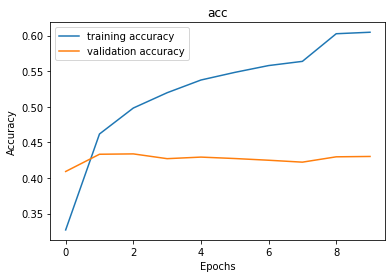

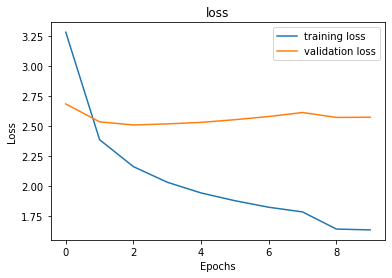


learning rate: 0.01
Epoch 0/9
----------
train Loss: 3.6475 Acc: 0.3280
val Loss: 3.5689 Acc: 0.3633

Epoch 1/9
----------
train Loss: 3.0508 Acc: 0.4193
val Loss: 3.8953 Acc: 0.3613

Epoch 2/9
----------
train Loss: 2.9983 Acc: 0.4387
val Loss: 4.2029 Acc: 0.3575

Epoch 3/9
----------
train Loss: 2.9763 Acc: 0.4500
val Loss: 4.3476 Acc: 0.3569

Epoch 4/9
----------
train Loss: 2.9319 Acc: 0.4608
val Loss: 4.4986 Acc: 0.3595

Epoch 5/9
----------
train Loss: 2.9308 Acc: 0.4657
val Loss: 4.6828 Acc: 0.3560

Epoch 6/9
----------
train Loss: 2.9550 Acc: 0.4693
val Loss: 4.8370 Acc: 0.3599

Epoch 7/9
----------
train Loss: 2.9473 Acc: 0.4728
val Loss: 4.8842 Acc: 0.3621

Epoch 8/9
----------
train Loss: 1.9967 Acc: 0.5770
val Loss: 4.3396 Acc: 0.3858

Epoch 9/9
----------
train Loss: 1.7899 Acc: 0.5982
val Loss: 4.2164 Acc: 0.3866

Training complete in 23m 60s
Best val Acc: 0.386600


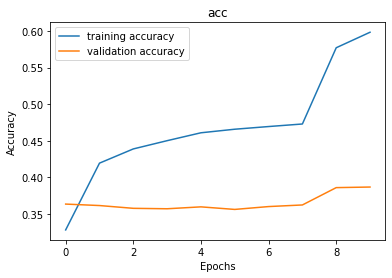

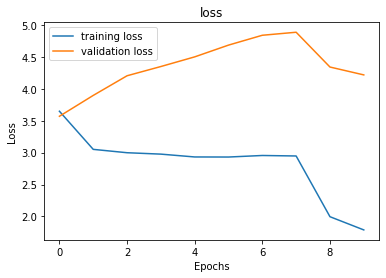


best validation accuracy tensor(0.4338, device='cuda:0', dtype=torch.float64)


In [7]:
# Fine tune only the last layer
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    model = torchvision.models.densenet169(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
#     torch.save(best_model.state_dict(), './models/dense169_best_model_state_dict1.pt')
print("best validation accuracy", max_acc)

##### Fine tune the whole layers

learning rate: 1e-05
Epoch 0/9
----------
train Loss: 5.1661 Acc: 0.0283
val Loss: 4.8563 Acc: 0.0799

Epoch 1/9
----------
train Loss: 4.5138 Acc: 0.1595
val Loss: 4.2303 Acc: 0.2215

Epoch 2/9
----------
train Loss: 3.8912 Acc: 0.2919
val Loss: 3.6702 Acc: 0.3257

Epoch 3/9
----------
train Loss: 3.3573 Acc: 0.3820
val Loss: 3.2040 Acc: 0.3891

Epoch 4/9
----------
train Loss: 2.9241 Acc: 0.4446
val Loss: 2.8459 Acc: 0.4347

Epoch 5/9
----------
train Loss: 2.5853 Acc: 0.4924
val Loss: 2.5779 Acc: 0.4721

Epoch 6/9
----------
train Loss: 2.3169 Acc: 0.5318
val Loss: 2.3798 Acc: 0.4969

Epoch 7/9
----------
train Loss: 2.0982 Acc: 0.5655
val Loss: 2.2234 Acc: 0.5151

Epoch 8/9
----------
train Loss: 1.9610 Acc: 0.5926
val Loss: 2.2114 Acc: 0.5165

Epoch 9/9
----------
train Loss: 1.9422 Acc: 0.5960
val Loss: 2.1973 Acc: 0.5178

Training complete in 55m 28s
Best val Acc: 0.517800


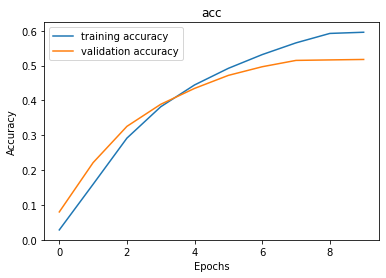

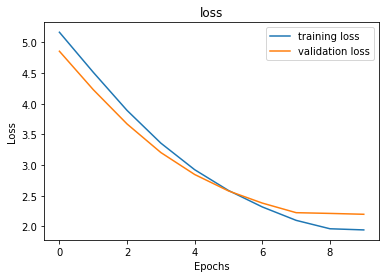


learning rate: 0.0001
Epoch 0/9
----------
train Loss: 3.3337 Acc: 0.3409
val Loss: 2.0906 Acc: 0.5251

Epoch 1/9
----------
train Loss: 1.6406 Acc: 0.6159
val Loss: 1.6413 Acc: 0.5988

Epoch 2/9
----------
train Loss: 1.0503 Acc: 0.7463
val Loss: 1.5433 Acc: 0.6191

Epoch 3/9
----------
train Loss: 0.6459 Acc: 0.8479
val Loss: 1.5529 Acc: 0.6175

Epoch 4/9
----------
train Loss: 0.3596 Acc: 0.9236
val Loss: 1.6055 Acc: 0.6195

Epoch 5/9
----------
train Loss: 0.1805 Acc: 0.9692
val Loss: 1.6660 Acc: 0.6149

Epoch 6/9
----------
train Loss: 0.0854 Acc: 0.9894
val Loss: 1.7262 Acc: 0.6165

Epoch 7/9
----------
train Loss: 0.0403 Acc: 0.9968
val Loss: 1.7649 Acc: 0.6153

Epoch 8/9
----------
train Loss: 0.0206 Acc: 0.9989
val Loss: 1.7670 Acc: 0.6136

Epoch 9/9
----------
train Loss: 0.0172 Acc: 0.9993
val Loss: 1.7652 Acc: 0.6143

Training complete in 55m 26s
Best val Acc: 0.619500


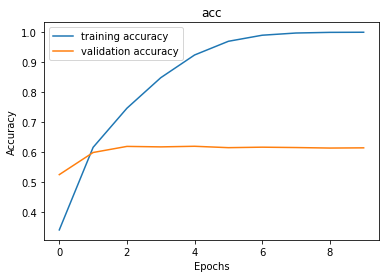

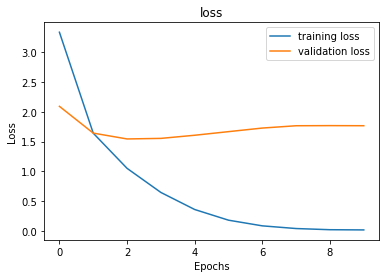


learning rate: 0.001
Epoch 0/9
----------
train Loss: 2.4518 Acc: 0.4220
val Loss: 2.1734 Acc: 0.4751

Epoch 1/9
----------
train Loss: 1.5365 Acc: 0.6036
val Loss: 1.9389 Acc: 0.5220

Epoch 2/9
----------
train Loss: 1.1226 Acc: 0.6962
val Loss: 1.9348 Acc: 0.5354

Epoch 3/9
----------
train Loss: 0.8039 Acc: 0.7755
val Loss: 1.9887 Acc: 0.5493

Epoch 4/9
----------
train Loss: 0.5641 Acc: 0.8367
val Loss: 2.1455 Acc: 0.5408

Epoch 5/9
----------
train Loss: 0.3905 Acc: 0.8853
val Loss: 2.2515 Acc: 0.5332

Epoch 6/9
----------
train Loss: 0.2812 Acc: 0.9142
val Loss: 2.2989 Acc: 0.5523

Epoch 7/9
----------
train Loss: 0.2371 Acc: 0.9275
val Loss: 2.3732 Acc: 0.5380

Epoch 8/9
----------
train Loss: 0.0771 Acc: 0.9807
val Loss: 1.9864 Acc: 0.6060

Epoch 9/9
----------
train Loss: 0.0178 Acc: 0.9994
val Loss: 1.9833 Acc: 0.6129

Training complete in 55m 17s
Best val Acc: 0.612900


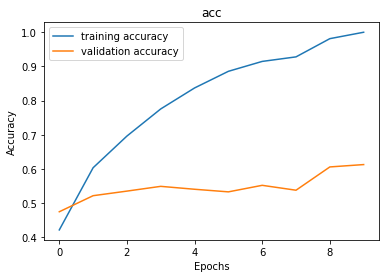

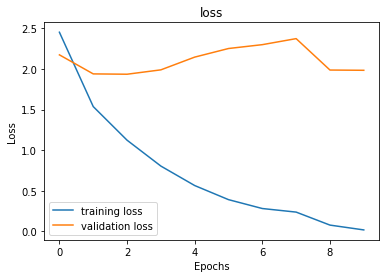


learning rate: 0.01
Epoch 0/9
----------
train Loss: 5.2638 Acc: 0.0211
val Loss: 4.7974 Acc: 0.0432

Epoch 1/9
----------
train Loss: 4.4861 Acc: 0.0803
val Loss: 4.4158 Acc: 0.0864

Epoch 2/9
----------
train Loss: 3.8640 Acc: 0.1561
val Loss: 4.0168 Acc: 0.1366

Epoch 3/9
----------
train Loss: 3.4190 Acc: 0.2278
val Loss: 3.9686 Acc: 0.1600

Epoch 4/9
----------
train Loss: 3.1508 Acc: 0.2726
val Loss: 3.5243 Acc: 0.2116

Epoch 5/9
----------
train Loss: 2.9417 Acc: 0.3100
val Loss: 3.6679 Acc: 0.2081

Epoch 6/9
----------
train Loss: 2.7613 Acc: 0.3437
val Loss: 3.3921 Acc: 0.2504

Epoch 7/9
----------
train Loss: 2.6086 Acc: 0.3763
val Loss: 3.0281 Acc: 0.3084

Epoch 8/9
----------
train Loss: 2.1571 Acc: 0.4702
val Loss: 2.7082 Acc: 0.3734

Epoch 9/9
----------
train Loss: 2.0011 Acc: 0.5034
val Loss: 2.7077 Acc: 0.3784

Training complete in 54m 59s
Best val Acc: 0.378400


In [ ]:
# Fine tune only the last layer
learning_rates = [1e-5, 1e-4, 1e-3, 1e-2]
max_acc = 0

for lr in learning_rates:
    print("learning rate:", lr)
    model = torchvision.models.densenet169(pretrained=True)
#     for param in model.parameters():
#         param.requires_grad = False
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)
    model, tr_acc, val_acc, tr_loss, val_loss = train_model(model, criterion, optimizer_ft, scheduler, num_epochs=10)
    if max(val_acc) > max_acc:
        best_model = model
        max_acc = max(val_acc)

    plot_result(range(10), tr_acc, val_acc, 'acc', 'Accuracy')
    plot_result(range(10), tr_loss, val_loss, 'loss', 'Loss')
    print('='*30)
    print()
torch.save(best_model.state_dict(), './models/dense169_best_model_state_dict.pt')
print("best validation accuracy", max_acc)